# Import libraries

In [19]:
from getdist import plots, MCSamples
import jax.numpy as jnp
import numpy as np

from cosmologix.likelihoods import DiagMuMeasurements, Chi2
from cosmologix import distances, likelihoods, fitter, display
from cosmologix.parameters import get_cosmo_params

from skysurvey_sniapop import agepop

cosmo_param = {}
cosmology = get_cosmo_params(**cosmo_param)
# Omega_b_h2 fixed since there is no CMB data.
free_params_names = ["w", "wa", "Omega_bc"]
fixed_params = {k: v for k, v in cosmology.items()  if k not in free_params_names}

# Class definition

In [20]:
class DiagSNIaMuMeasurements(Chi2):
    """Likelihood for independent measurements of distance modulus.

    Note:
        Using this prior introduces a new nuisance parameter "M", the absolute
        magnitude of Supernovae. Be careful when combining several supernovae
        measurements, as they will all share the same nuisance parameter.
    """

    def __init__(self, z_cmb, mu, mu_err, coefs={}):
        """Initializes the DiagMuMeasurements class.

        Args:
            z_cmb (jnp.ndarray): Redshifts of the measurements.
            mu (jnp.ndarray): Distance moduli.
            mu_err (jnp.ndarray): Errors on the distance moduli.
            coefs (dict): standardisation parameters
        """
        self.z_cmb = jnp.atleast_1d(z_cmb)
        self.data = jnp.atleast_1d(mu)
        self.error = jnp.atleast_1d(mu_err)
        self.coefs = {k: jnp.atleast_1d(v) for k, v in coefs.items()}

    def model(self, params):
        """Calculates the model for the distance modulus.

        Args:
            params (dict): A dictionary of model parameters.

        Returns:
            jnp.ndarray: The predicted distance moduli.
        """
        # model the bias | all depends on how much you now "agebias"
        #bias_corr = (agepop.delta_z(self.z_cmb, phi=3.5) - 0.5) * params["agebias"]
        bias_corr = (agepop.delta_z(self.z_cmb)-0.35)*params["agebias"]
        magabs = params["M"] + bias_corr

        # evolving beta
        beta = params["beta"] + self.z_cmb * params["dbeta_dz"]
        
        standardisation = self.coefs["x1"] * params["alpha"] + \
                          self.coefs["c"] * beta +\
                          self.coefs["p"] * params["gamma"]


        
        # correct the bias.
        return distances.mu(params, self.z_cmb) + magabs + standardisation

    def initial_guess(self, params):
        """Appends starting points for nuisance parameters.

        Args:
            params (dict): The initial parameter dictionary.

        Returns:
            dict: The updated parameter dictionary.
        """
        return dict(params, M=0.0, agebias=0, alpha=-0.15, beta=3.15, gamma=0.1, 
                    dbeta_dz=0)

# Functions definitions

In [21]:
def likelihood_to_results(likelihood,fixed_params,
                          prior_om=0.001, which="fisher",
                          prior_model = {}, 
                          grid_param_space={"w": [-1.3, -0.5, 100], 
                                            "wa": [-1, 0.5, 100]}):

    likelihoods_and_priors = [likelihood] 
    if prior_om is not None:
        prior_ = Chi2("Omega_bc", cosmology.get('Omega_bc'), prior_om)
        likelihoods_and_priors.append(prior_)
        
    if prior_model is not None:
        for k, v in prior_model.items():
            print(v)
            prior_ = Chi2(k, v["loc"], v["scale"])
            
            likelihoods_and_priors.append(prior_)

    # results of interest
    if which == "fisher":
        from cosmologix import fitter
        result = fitter.fit(likelihoods_and_priors, fixed=fixed_params)

    elif which == "grid":
        from cosmologix import contours
        result = contours.frequentist_contour_2d_sparse(likelihoods_and_priors,
                                                       grid=grid_param_space,
                                                       fixed=fixed_params)
    else:
        raise NotImplementedError(f"Only which = 'fisher' or 'grid' has been implemented. {which=} given.")

    return result

# Load data

In [22]:
df = pd.read_parquet("../data/inference_data_frame.parquet")

In [23]:
z_cmb   = df["z"].to_numpy()
mu_err  = df["magobs_err"].to_numpy()

coefs = {
    "x1": df["x1"].to_numpy(),
    "c":  df["c"].to_numpy(),
    "p":  df["prompt"].to_numpy()
}

In [24]:
mu_data = df["magobs"].to_numpy() \
         + (agepop.psi_z(z_cmb) - 0.35) * 0.18

In [37]:
likelihood = DiagSNIaMuMeasurements(
    z_cmb,
    mu_data,
    mu_err,
    coefs=coefs
)

In [41]:
params0 = likelihood.initial_guess({})
# for k, v in fixed_params.items():
#     params0[k] = v
# full_params0 = cosmology.fill_default_params(params0)
# param_names = list(full_params0.keys())
print(params0)

{'M': 0.0, 'agebias': 0, 'alpha': -0.15, 'beta': 3.15, 'gamma': 0.1, 'dbeta_dz': 0}


# Inference

In [26]:
which = "fisher"

result = likelihood_to_results(
    likelihood,
    fixed_params=fixed_params,
    prior_model={
        "dbeta_dz": {"loc":0., "scale":0.001},
        "agebias":  {"loc":0., "scale":0.001}
    },
    prior_om=0.02,
    which=which
)

# result_nodrift = likelihood_to_results(
#     likelihood,
#     fixed_params=fixed_params,
#     prior_model={
#         "dbeta_dz": {"loc":0., "scale":0.001},
#     },
#     prior_om=0.02,
#     which=which
# )

{'loc': 0.0, 'scale': 0.001}
{'loc': 0.0, 'scale': 0.001}


# MCMC

In [42]:
param_names = ["w", "wa", "Omega_bc", "M", "agebias", "alpha", "beta", "gamma", "dbeta_dz"]

# parameters of interest
params = ["alpha", "beta", "M"]
indices = [param_names.index(p) for p in params]   

mu = np.array(result["x"])                          # best-fit values
cov = np.array(result["inverse_FIM"])               # covariance = inverse Fisher

mu_sub  = mu[indices]
cov_sub = cov[np.ix_(indices, indices)]

In [43]:
rng = np.random.default_rng(0)
Nsamp = 50_000   # enough for smooth contours

samples_arr = rng.multivariate_normal(mu_sub, cov_sub, size=Nsamp)

samples = MCSamples(
    samples=samples_arr,
    names=params,
    labels=params
)

Removed no burn in


# Plot result

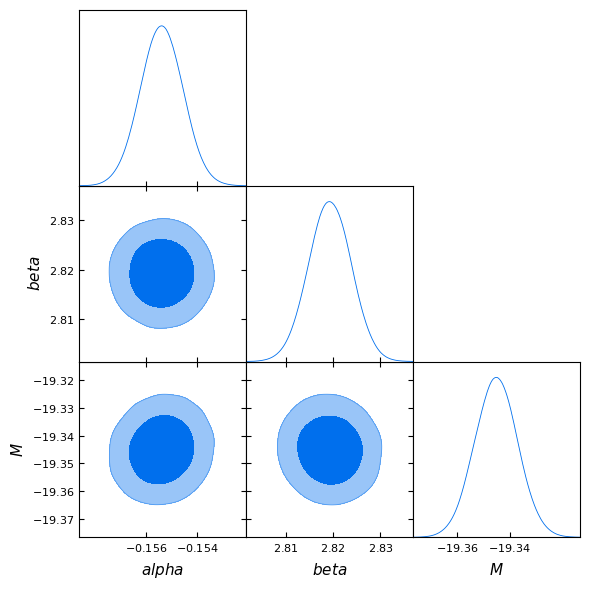

In [44]:
g = plots.get_subplot_plotter()
g.triangle_plot(
    [samples],
    params=params,
    filled=True
)